In [1]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z]|"
           "E P I L O G U E)\s+" +                   # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|"
           "This\s+book\s+was\s+art\s+directed\s+|"
           "E P I L O G U E)")                       # chapter contents ends with a new chapter, epilogue or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)
hp["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

79,210 words in Harry Potter and the Sorcerer's Stone
87,453 words in Harry Potter and the Chamber of Secrets
111,286 words in Harry Potter and the Prisoner of Azkaban
197,990 words in Harry Potter and the Goblet of Fire
266,228 words in Harry Potter and the Order of the Phoenix
174,462 words in Harry Potter and the Half-Blood Prince
202,277 words in Harry Potter and the Deathly Hallows

1,118,906 total words in collection


In [5]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.55 Average word length in Harry Potter and the Sorcerer's Stone
5.64 Average word length in Harry Potter and the Chamber of Secrets
5.64 Average word length in Harry Potter and the Prisoner of Azkaban
5.60 Average word length in Harry Potter and the Goblet of Fire
5.63 Average word length in Harry Potter and the Order of the Phoenix
5.65 Average word length in Harry Potter and the Half-Blood Prince
5.65 Average word length in Harry Potter and the Deathly Hallows


In [6]:
# Chapters in books
for book in hp:
    chapters = 0
    for chapter in hp[book]:
        chapters += 1
    print('{} chapters in {}'.format(chapters, book))

17 chapters in Harry Potter and the Sorcerer's Stone
18 chapters in Harry Potter and the Chamber of Secrets
22 chapters in Harry Potter and the Prisoner of Azkaban
37 chapters in Harry Potter and the Goblet of Fire
38 chapters in Harry Potter and the Order of the Phoenix
30 chapters in Harry Potter and the Half-Blood Prince
37 chapters in Harry Potter and the Deathly Hallows


In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets — but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petu

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'the

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'and', 'mrs_dursley', 'of', 'number_four_privet_drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr_dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs_dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'their', 'opinion', 'th

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mr', 'mrs', 'dursley', 'number_four', 'privet_drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'mr', 'dursley', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'dursley', 'small', 'son', 'call', 'dudley', 'opinion', 'fine', 'boy', 'anywhere', 'dursley', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'would', 'discover', 'think', 'could', 'bear', 'anyone', 'find', 'potter', 'mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'year', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'dursley', 'shudder', 'think', 'neighbor', 'wo

In [13]:
print(data_lemmatized[19])

['ron', 'breathe', 'harry', 'creep', 'window', 'pushing', 'could', 'talk', 'bar', 'ron', 'harry', 'mouth', 'fall', 'open', 'full', 'impact', 'see', 'hit', 'ron', 'lean', 'back', 'window', 'old', 'turquoise', 'car', 'park', 'midair', 'grin', 'harry', 'front', 'seat', 'fr', 'george', 'ron', 'eld', 'twin', 'brother', 'right', 'harry', 'ask', 'george', 'go', 'say', 'ron', 'answering', 'letter', 'ask', 'stay', 'twelve', 'time', 'dad', 'come', 'home', 'say', 'get', 'official', 'warning', 'use', 'magic', 'front', 'muggle', 'know', 'work', 'ministry', 'say', 'ron', 'know', 'suppose', 'spell', 'outside', 'school', 'talk', 'say', 'harry', 'star', 'float', 'car', 'oh', 'count', 'say', 'ron', 'borrow', 'dad', 'enchant', 'magic', 'front', 'muggle', 'live', 'tell', 'take', 'long', 'explain', 'look', 'tell', 'hogwart', 'dursley', 'lock', 'let', 'come', 'back', 'obviously', 'magic', 'ministry', 'think', 'second', 'spell', 'do', 'three', 'day', 'stop', 'gibber', 'say', 'ron', 'come', 'take', 'home', '-

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 10), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 4), (40, 2), (41, 15), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 4), (71, 2), (72, 5), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 9), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 9), (108, 1), (109, 3), (110, 

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 2),
  ('able', 2),
  ('across', 2),
  ('act', 2),
  ('admire', 1),
  ('affect', 1),
  ('afternoon', 1),
  ('age', 1),
  ('agree', 1),
  ('air', 3),
  ('albus', 3),
  ('allow', 2),
  ('almost', 5),
  ('also', 2),
  ('although', 2),
  ('always', 2),
  ('amount', 1),
  ('amuse', 1),
  ('angrily', 2),
  ('angry', 1),
  ('another', 3),
  ('answer', 1),
  ('anxious', 1),
  ('anyone', 2),
  ('anything', 5),
  ('anywhere', 1),
  ('apart', 1),
  ('appear', 2),
  ('approve', 1),
  ('arm', 3),
  ('armchair', 1),
  ('around', 10),
  ('arrive', 3),
  ('ask', 3),
  ('astonishing', 1),
  ('astounding', 1),
  ('astride', 1),
  ('aunt', 2),
  ('awake', 1),
  ('away', 4),
  ('baby', 2),
  ('back', 15),
  ('bag', 1),
  ('baker', 1),
  ('bakery', 1),
  ('ball', 1),
  ('bathroom', 1),
  ('beady', 1),
  ('bear', 3),
  ('beard', 2),
  ('bed', 3),
  ('bedroom', 1),
  ('beefy', 1),
  ('behave', 1),
  ('behavior', 1),
  ('behind', 1),
  ('believe', 3),
  ('belt', 1),
  ('bend', 1),
  ('beneath', 1)

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"harry" + 0.000*"say" + 0.000*"ron" + 0.000*"hermione" + 0.000*"look" '
  '+ 0.000*"see" + 0.000*"know" + 0.000*"back" + 0.000*"like" + 0.000*"think"'),
 (1,
  '0.009*"ferret" + 0.004*"pus" + 0.004*"eurgh" + 0.002*"moody" + '
  '0.002*"bubotuber" + 0.002*"stepladder" + 0.002*"neptune" + 0.001*"scummy" + '
  '0.001*"deform" + 0.001*"rambling"'),
 (2,
  '0.000*"harry" + 0.000*"say" + 0.000*"ron" + 0.000*"look" + 0.000*"go" + '
  '0.000*"hermione" + 0.000*"see" + 0.000*"know" + 0.000*"back" + 0.000*"get"'),
 (3,
  '0.000*"harry" + 0.000*"say" + 0.000*"get" + 0.000*"ron" + 0.000*"hermione" '
  '+ 0.000*"look" + 0.000*"see" + 0.000*"go" + 0.000*"know" + 0.000*"like"'),
 (4,
  '0.000*"say" + 0.000*"harry" + 0.000*"ron" + 0.000*"dumbledore" + '
  '0.000*"look" + 0.000*"get" + 0.000*"go" + 0.000*"see" + 0.000*"know" + '
  '0.000*"hermione"'),
 (5,
  '0.034*"say" + 0.033*"harry" + 0.012*"ron" + 0.012*"look" + 0.011*"hermione" '
  '+ 0.008*"know" + 0.007*"get" + 0.007*"dumbledore" 

In [18]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.507415001559586
Coherence Score:  0.340650862539951


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('snape', 0.12081648883292465),
   ('lupin', 0.039233878984690836),
   ('black', 0.036251573994300484),
   ('potter', 0.015905626615415204),
   ('professor', 0.014646431175028167),
   ('dementor', 0.011399032407714229),
   ('sirius', 0.010935118298097951),
   ('professor_mcgonagall', 0.010868844853867056),
   ('office', 0.010670024521174366),
   ('turn', 0.010471204188481676)]),
 (1,
  [('hermione', 0.032794026135656504),
   ('harry', 0.02700684505289359),
   ('tree', 0.019663970130678284),
   ('ground', 0.017485998755444928),
   ('head', 0.013254511512134411),
   ('forest', 0.013254511512134411),
   ('window', 0.00939639079029247),
   ('move', 0.009271935283136279),
   ('castle', 0.009209707529558183),
   ('hear', 0.009023024268823895)]),
 (2,
  [('uncle_vernon', 0.03537425497329515),
   ('dudley', 0.03359393141884047),
   ('dursley', 0.02391825992723895),
   ('harry', 0.022602368604381144),
   ('aunt_petunia', 0.017648424800681167),
   ('owl', 0.01408777769177181),
   ('lette

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


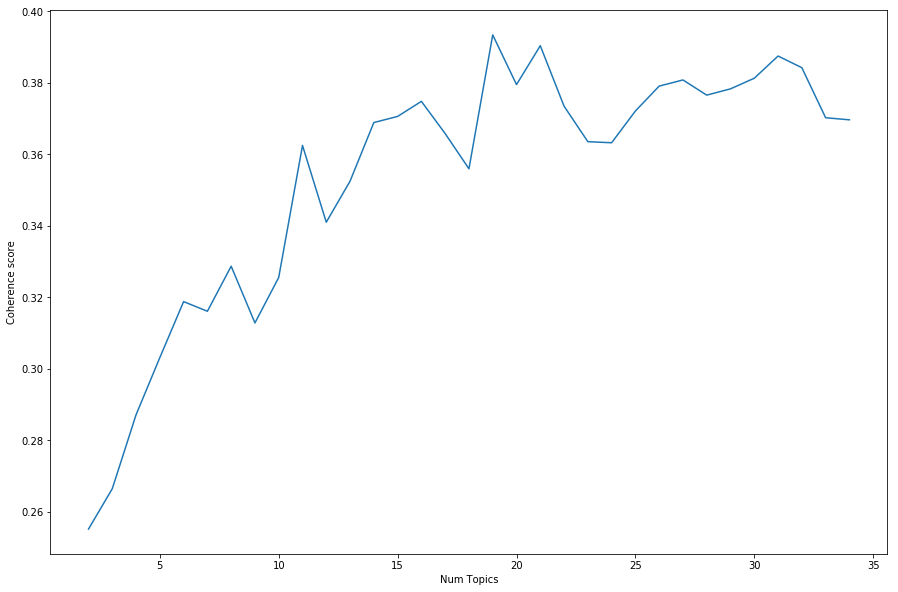

In [24]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.255134
Num Topics = 3  has Coherence Value of 0.266429
Num Topics = 4  has Coherence Value of 0.2871
Num Topics = 5  has Coherence Value of 0.303098
Num Topics = 6  has Coherence Value of 0.318761
Num Topics = 7  has Coherence Value of 0.316058
Num Topics = 8  has Coherence Value of 0.328658
Num Topics = 9  has Coherence Value of 0.3128
Num Topics = 10  has Coherence Value of 0.325518
Num Topics = 11  has Coherence Value of 0.362434
Num Topics = 12  has Coherence Value of 0.340966
Num Topics = 13  has Coherence Value of 0.352455
Num Topics = 14  has Coherence Value of 0.368842
Num Topics = 15  has Coherence Value of 0.370555
Num Topics = 16  has Coherence Value of 0.374769
Num Topics = 17  has Coherence Value of 0.365754
Num Topics = 18  has Coherence Value of 0.355912
Num Topics = 19  has Coherence Value of 0.393355
Num Topics = 20  has Coherence Value of 0.379458
Num Topics = 21  has Coherence Value of 0.390332
Num Topics = 22  has Coherence V

In [26]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.055*"harry" + 0.031*"wand" + 0.012*"hand" + 0.011*"face" + 0.011*"back" + '
  '0.010*"death_eater" + 0.009*"potter" + 0.009*"light" + 0.009*"door" + '
  '0.008*"floor"'),
 (1,
  '0.036*"harry" + 0.013*"back" + 0.011*"voice" + 0.011*"feel" + 0.010*"head" '
  '+ 0.009*"eye" + 0.009*"dark" + 0.009*"sound" + 0.009*"walk" + '
  '0.009*"reach"'),
 (2,
  '0.033*"harry" + 0.014*"mr_weasley" + 0.012*"door" + 0.011*"wizard" + '
  '0.008*"hogwart" + 0.007*"percy" + 0.007*"fr" + 0.007*"muggle" + '
  '0.007*"large" + 0.007*"witch"'),
 (3,
  '0.115*"ron" + 0.107*"hermione" + 0.099*"harry" + 0.010*"back" + '
  '0.009*"yeah" + 0.009*"find" + 0.009*"make" + 0.008*"time" + 0.008*"malfoy" '
  '+ 0.008*"-PRON-"'),
 (4,
  '0.014*"umbridge" + 0.013*"professor" + 0.009*"class" + 0.008*"harry" + '
  '0.008*"year" + 0.008*"lesson" + 0.007*"voice" + 0.007*"turn" + 0.007*"hand" '
  '+ 0.007*"neville"'),
 (5,
  '0.079*"hagrid" + 0.052*"harry" + 0.018*"uncle_vernon" + 0.018*"yeh" + '
  '0.017*"dudley" + 

In [27]:
optimal_model.show_topic(0,10)

[('harry', 0.054567749846719804),
 ('wand', 0.030928537366305606),
 ('hand', 0.0121261666326044),
 ('face', 0.011081590480732111),
 ('back', 0.010536594227581353),
 ('death_eater', 0.009650975316211367),
 ('potter', 0.009492018075709064),
 ('light', 0.009196811771919068),
 ('door', 0.008742648227626769),
 ('floor', 0.008197651974476009)]

In [28]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['harry', 'wand', 'hand', 'face', 'back', 'death_eater', 'potter', 'light', 'door', 'floor']
Topic 1: ['harry', 'back', 'voice', 'feel', 'head', 'eye', 'dark', 'sound', 'walk', 'reach']
Topic 2: ['harry', 'mr_weasley', 'door', 'wizard', 'hogwart', 'percy', 'fr', 'muggle', 'large', 'witch']
Topic 3: ['ron', 'hermione', 'harry', 'back', 'yeah', 'find', 'make', 'time', 'malfoy', '-PRON-']
Topic 4: ['umbridge', 'professor', 'class', 'harry', 'year', 'lesson', 'voice', 'turn', 'hand', 'neville']
Topic 5: ['hagrid', 'harry', 'uncle_vernon', 'yeh', 'dudley', 'ter', 'back', 'dursley', '-PRON-', 'aunt_petunia']
Topic 6: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin', 'professor_mcgonagall', 'filch', 'weasley', 'face', 'team']
Topic 7: ['snape', 'harry', 'lupin', 'black', 'fudge', 'sirius', 'dementor', 'eye', 'potter', 'door']
Topic 8: ['wand', 'make', 'wizard', 'goblin', 'sword', 'hand', 'albus', 'griphook', 'horcrux', 'scrimgeour']
Topic 9: ['dumbledore', 'harry', 'voldemort', '

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.3791,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...","Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,5.0,0.5056,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...",Nearly ten years had passed since the Dursleys...
2,2,5.0,0.5267,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...",The escape of the Brazilian boa constrictor ea...
3,3,5.0,0.5316,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...",BOOM. They knocked again. Dudley jerked awake....
4,4,2.0,0.3571,"harry, mr_weasley, door, wizard, hogwart, perc...",Harry woke early the next morning. Although he...
5,5,2.0,0.4255,"harry, mr_weasley, door, wizard, hogwart, perc...",Harry's last month with the Dursleys wasn't fu...
6,6,6.0,0.3706,"harry, malfoy, ron, gryffindor, slytherin, pro...","The door swung open at once. A tall, black-hai..."
7,7,4.0,0.2081,"umbridge, professor, class, harry, year, lesso...","There, look."" ""Where?"" ""Next to the tall kid w..."
8,8,6.0,0.4024,"harry, malfoy, ron, gryffindor, slytherin, pro...",Harry had never believed he would meet a boy h...
9,9,6.0,0.4066,"harry, malfoy, ron, gryffindor, slytherin, pro...",alfoy couldn't believe his eyes when he saw th...


In [30]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
14,14,1.0,0.4029,"harry, back, voice, feel, head, eye, dark, sou...",Things couldn't have been worse. Filch took th...
15,15,1.0,0.2344,"harry, back, voice, feel, head, eye, dark, sou...","In years to come, Harry would never quite reme..."
31,31,1.0,0.4457,"harry, back, voice, feel, head, eye, dark, sou...",Summer was creeping over the grounds around th...
33,33,1.0,0.2629,"harry, back, voice, feel, head, eye, dark, sou...","He was standing at the end of a very long, dim..."
50,50,1.0,0.2157,"harry, back, voice, feel, head, eye, dark, sou...",Harry's euphoria at finally winning the Quiddi...
51,51,1.0,0.2688,"harry, back, voice, feel, head, eye, dark, sou...",Harry's mind had gone blank with shock. The th...
54,54,1.0,0.3110,"harry, back, voice, feel, head, eye, dark, sou...",Harry had never been part of a stranger group....
88,88,0.0,0.4940,"harry, wand, hand, face, back, death_eater, po...",Harry felt his feet slam into the ground; his ...
90,90,0.0,0.5760,"harry, wand, hand, face, back, death_eater, po...","Wormtail approached Harry, who scrambled to fi..."
123,123,1.0,0.2838,"harry, back, voice, feel, head, eye, dark, sou...",The story of Fred and George's flight to freed...


In [31]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['harry,',
  'mr_weasley,',
  'door,',
  'wizard,',
  'hogwart,',
  'percy,',
  'fr,',
  'muggle,',
  'large,',
  'witch'],
 ['harry,',
  'mr_weasley,',
  'door,',
  'wizard,',
  'hogwart,',
  'percy,',
  'fr,',
  'muggle,',
  'large,',
  'witch'],
 ['harry,',
  'malfoy,',
  'ron,',
  'gryffindor,',
  'slytherin,',
  'professor_mcgonagall,',
  'filch,',
  'weasley,',
  'face,',
  'team'],
 ['umbridge,',
  'professor,',
  'class,',
  'harry,',
  'year,',
  'le

In [32]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['hagrid', 'harry', 'uncle_vernon', 'yeh', 'dudley']
1. Dominant keywords: ['hagrid', 'harry', 'uncle_vernon', 'yeh', 'dudley']
2. Dominant keywords: ['hagrid', 'harry', 'uncle_vernon', 'yeh', 'dudley']
3. Dominant keywords: ['hagrid', 'harry', 'uncle_vernon', 'yeh', 'dudley']
4. Dominant keywords: ['harry', 'mr_weasley', 'door', 'wizard', 'hogwart']
5. Dominant keywords: ['harry', 'mr_weasley', 'door', 'wizard', 'hogwart']
6. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
7. Dominant keywords: ['umbridge', 'professor', 'class', 'harry', 'year']
8. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
9. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
10. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
11. Dominant keywords: ['harry', 'mr_weasley', 'door', 'wizard', 'hogwart']
12. Dominant keywords: ['harry', 'malfoy', 'ron', 'gryffindor', 'slytherin']
13. Dominant keywo

In [33]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6647,"harry, wand, hand, face, back, death_eater, po...",Black shapes were emerging out of thin air all...
1,1.0,0.4457,"harry, back, voice, feel, head, eye, dark, sou...",Summer was creeping over the grounds around th...
2,2.0,0.4672,"harry, mr_weasley, door, wizard, hogwart, perc...",Harry awoke at half-past five the next morning...
3,3.0,0.3643,"ron, hermione, harry, back, yeah, find, make, ...","Where was Dumbledore, and what was he doing? H..."
4,4.0,0.5289,"umbridge, professor, class, harry, year, lesso...",They had expected to have to comb Hermione's D...
5,5.0,0.5316,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...",BOOM. They knocked again. Dudley jerked awake....
6,6.0,0.4896,"harry, malfoy, ron, gryffindor, slytherin, pro...","He — he sent me this,"" Hermione said, holding ..."
7,7.0,0.5014,"snape, harry, lupin, black, fudge, sirius, dem...",It took a few seconds for the absurdity of thi...
8,8.0,0.3766,"wand, make, wizard, goblin, sword, hand, albus...",Harry turned to look at Ron and Hermione. Neit...
9,9.0,0.6516,"dumbledore, harry, voldemort, boy, make, time,...",Harry could feel the Felix Felicis wearing off...


In [34]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: harry, wand, hand, face, back, death_eater, potter, light, door, floor

Black shapes were emerging out of thin air all around them, blocking their way left and right; eyes glinted through slits in hoods, a dozen lit wand tips were pointing directly at their hearts. Ginny gave a gasp of horror. "To me, Potter," repeated the drawling voice of Lucius Malfoy as he held out his hand, palm up. Harry's insides plummeted sickeningly. They were trapped and outnumbered two to one. "To me," said Malfoy yet again. "Where's Sirius?" Harry said. Several of the Death Eaters laughed. A harsh female voice from the midst of the shadowy figures to Harry's left said triumphantly, "The Dark Lord always knows!" "Always," echoed Malfoy softly. "Now, give me the prophecy, Potter." "I want to know where Sirius is!" "I want to know where Sirius is!" mimicked the woman to his left. She and her fellow Death Eaters had closed in so that they were mere feet away from Harry and the others, t

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"harry, wand, hand, face, back, death_eater, po...",19,0.0955
1,1.0,"harry, back, voice, feel, head, eye, dark, sou...",13,0.0653
2,2.0,"harry, mr_weasley, door, wizard, hogwart, perc...",22,0.1106
3,3.0,"ron, hermione, harry, back, yeah, find, make, ...",14,0.0704
4,4.0,"umbridge, professor, class, harry, year, lesso...",22,0.1106
5,5.0,"hagrid, harry, uncle_vernon, yeh, dudley, ter,...",15,0.0754
6,6.0,"harry, malfoy, ron, gryffindor, slytherin, pro...",24,0.1206
7,7.0,"snape, harry, lupin, black, fudge, sirius, dem...",12,0.0603
8,8.0,"wand, make, wizard, goblin, sword, hand, albus...",14,0.0704
9,9.0,"dumbledore, harry, voldemort, boy, make, time,...",17,0.0854


In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"harry, wand, hand, face, back, death_eater, potter, light, door, floor",19,0.0955
1,1.0,"harry, back, voice, feel, head, eye, dark, sound, walk, reach",13,0.0653
2,2.0,"harry, mr_weasley, door, wizard, hogwart, percy, fr, muggle, large, witch",22,0.1106
3,3.0,"ron, hermione, harry, back, yeah, find, make, time, malfoy, -PRON-",14,0.0704
4,4.0,"umbridge, professor, class, harry, year, lesson, voice, turn, hand, neville",22,0.1106
5,5.0,"hagrid, harry, uncle_vernon, yeh, dudley, ter, back, dursley, -PRON-, aunt_petunia",15,0.0754
6,6.0,"harry, malfoy, ron, gryffindor, slytherin, professor_mcgonagall, filch, weasley, face, team",24,0.1206
7,7.0,"snape, harry, lupin, black, fudge, sirius, dementor, eye, potter, door",12,0.0603
8,8.0,"wand, make, wizard, goblin, sword, hand, albus, griphook, horcrux, scrimgeour",14,0.0704
9,9.0,"dumbledore, harry, voldemort, boy, make, time, die, lord, riddle, return",17,0.0854


In [37]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [38]:
from nltk import tokenize

In [39]:
# Convert to list
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

In [40]:
# Convert to list
print('Creating corpus')
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Creating corpus
Tokenizing
Creating bigrams and trigrams


/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Building bigram and trigram models
Removing stopwords
Forming bigrams
Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [41]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [42]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


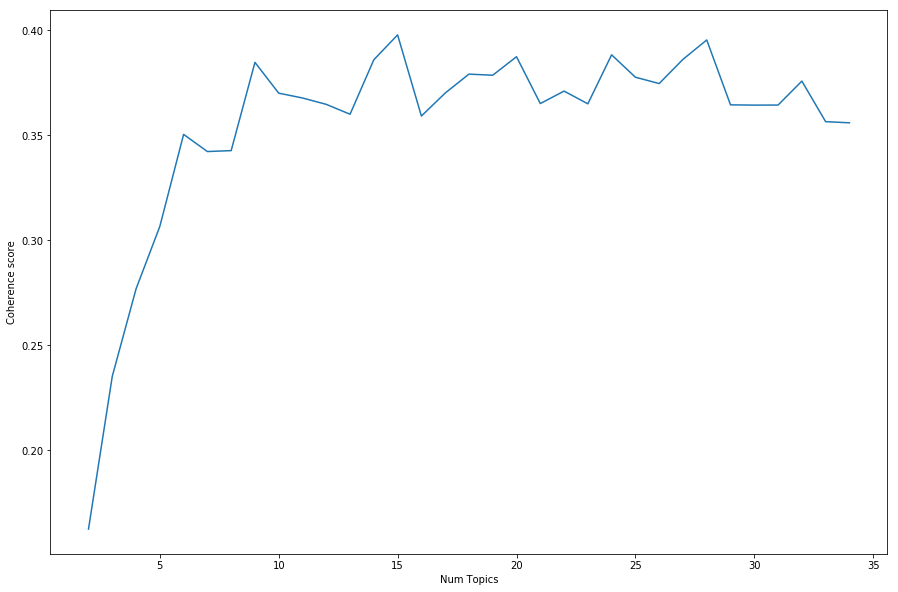

In [43]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.162352
Num Topics = 3  has Coherence Value of 0.235147
Num Topics = 4  has Coherence Value of 0.276798
Num Topics = 5  has Coherence Value of 0.306585
Num Topics = 6  has Coherence Value of 0.350426
Num Topics = 7  has Coherence Value of 0.342256
Num Topics = 8  has Coherence Value of 0.342689
Num Topics = 9  has Coherence Value of 0.384746
Num Topics = 10  has Coherence Value of 0.370064
Num Topics = 11  has Coherence Value of 0.367772
Num Topics = 12  has Coherence Value of 0.364731
Num Topics = 13  has Coherence Value of 0.360032
Num Topics = 14  has Coherence Value of 0.385994
Num Topics = 15  has Coherence Value of 0.397828
Num Topics = 16  has Coherence Value of 0.359168
Num Topics = 17  has Coherence Value of 0.370116
Num Topics = 18  has Coherence Value of 0.379142
Num Topics = 19  has Coherence Value of 0.378617
Num Topics = 20  has Coherence Value of 0.387439
Num Topics = 21  has Coherence Value of 0.365121
Num Topics = 22  has Coheren

In [45]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 6
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [46]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -8.296094328399201
Coherence Score:  0.2912340481732413


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [47]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['harry', 'hagrid', 'malfoy', 'mr', 'weasley', 'watch', 'ginny', 'neville', 'yeah', 'gryffindor']
Topic 1: ['dumbledore', 'voldemort', '-PRON-', 'potter', 'wizard', 'people', 'boy', 'kill', 'dobby', 'return']
Topic 2: ['harry', 'ron', 'hermione', 'head', 'turn', 'back', 'star', 'voice', 'shake', 'mouth']
Topic 3: ['harry', 'face', 'hand', 'snape', 'wand', 'feel', 'eye', 'point', 'pull', 'voice']
Topic 4: ['harry', 'make', 'time', 'give', 'sirius', 'lupin', 'stop', 'place', 'speak', 'man']
Topic 5: ['back', 'door', 'hear', 'open', 'room', 'sit', 'moment', 'leave', 'stand', 'front']
Topic 6: ['good', 'find', 'professor', 'thing', 'year', 'fr', 'happen', 'hogwart', 'george', 'talk']
Topic 7: ['black', 'foot', 'eye', 'long', 'dark', 'large', 'light', 'fall', 'floor', 'window']


In [48]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [50]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"harry, wand, hand, face, back, death_eater, potter, light, door, floor",37770.0,0.3590
1,1.0,"harry, back, voice, feel, head, eye, dark, sound, walk, reach",13988.0,0.1330
2,2.0,"harry, mr_weasley, door, wizard, hogwart, percy, fr, muggle, large, witch",11158.0,0.1061
3,3.0,"ron, hermione, harry, back, yeah, find, make, time, malfoy, -PRON-",8639.0,0.0821
4,4.0,"umbridge, professor, class, harry, year, lesson, voice, turn, hand, neville",8896.0,0.0846
5,5.0,"hagrid, harry, uncle_vernon, yeh, dudley, ter, back, dursley, -PRON-, aunt_petunia",8151.0,0.0775
6,6.0,"harry, malfoy, ron, gryffindor, slytherin, professor_mcgonagall, filch, weasley, face, team",9340.0,0.0888
7,7.0,"snape, harry, lupin, black, fudge, sirius, dementor, eye, potter, door",7266.0,0.0691
8,8.0,"wand, make, wizard, goblin, sword, hand, albus, griphook, horcrux, scrimgeour",NaN,NaN
9,9.0,"dumbledore, harry, voldemort, boy, make, time, die, lord, riddle, return",NaN,NaN
